In [1]:
from sklearn.datasets import fetch_lfw_people
from matplotlib import pyplot as plt
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(len(faces.target_names))
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
8
(1348, 62, 47)


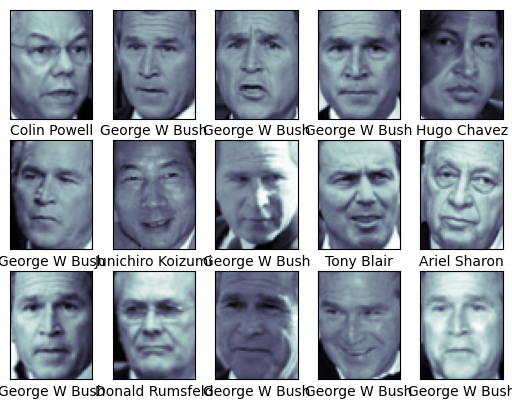

In [2]:
# contoh wajah yang digunakan

fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

In [3]:
faces.data[1]

array([0.28627452, 0.20784314, 0.2535948 , ..., 0.96993464, 0.95032686,
       0.9346406 ], dtype=float32)

In [4]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=100)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [5]:
# pemisahan data training dan data testing

from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42,stratify=faces.target)

In [6]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid,n_jobs=-1)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)
print(grid.best_score_)

CPU times: user 3.77 s, sys: 269 ms, total: 4.04 s
Wall time: 7.07 s
{'svc__C': 5, 'svc__gamma': 0.001}
0.8318489977076526


In [7]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Text(0.5, 0.98, 'Predicted Names; Incorrect Labels in Red')

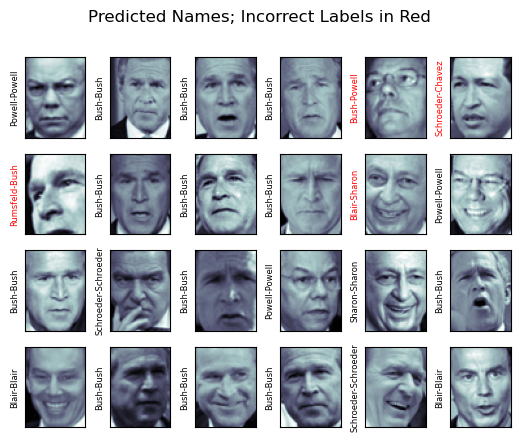

In [8]:
# hasil label pada data testing

fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1] + '-' + faces.target_names[ytest[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red', size=6)
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=12)

In [9]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.74      0.74      0.74        19
     Colin Powell       0.78      0.90      0.83        59
  Donald Rumsfeld       0.81      0.87      0.84        30
    George W Bush       0.94      0.89      0.92       133
Gerhard Schroeder       0.83      0.93      0.88        27
      Hugo Chavez       0.92      0.67      0.77        18
Junichiro Koizumi       0.92      0.73      0.81        15
       Tony Blair       0.86      0.89      0.88        36

         accuracy                           0.87       337
        macro avg       0.85      0.83      0.83       337
     weighted avg       0.87      0.87      0.87       337



Text(77.92222222222226, 0.5, 'predicted label')

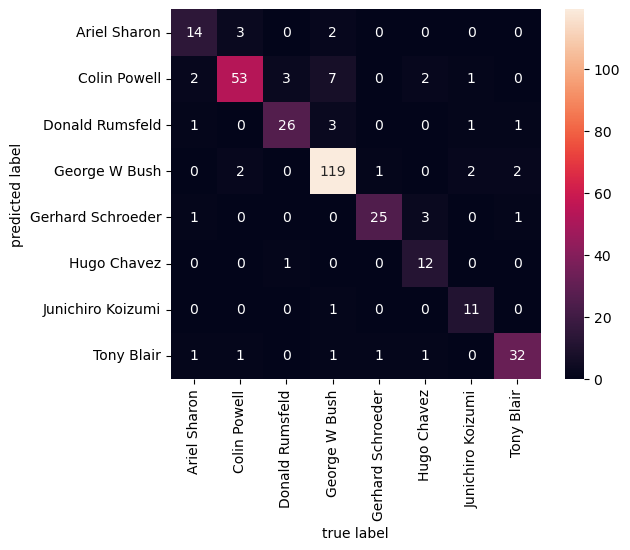

In [10]:
# bentuk confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [14]:
import cv2

# Initialize the face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detected_faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in detected_faces:
        roi = gray[y:y+h, x:x+w]
        roi = cv2.resize(roi, (47, 62))
        cv2.imshow('roi', roi)
        roi = roi.reshape(1, -1)
        roi = roi.astype('float32') / 255.0
        result = model.predict(roi)
        cv2.putText(frame, faces.target_names[result[0]], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

    cv2.imshow('frame', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()